## Dimensionality Reduction for Data Visualization

A supplementory notebook for the workshop talk on dimension reduction

### Installing the required libraries
In most cases, if you are running the code locally, you will need to install the libraries including the umap.
*Note* the correct library to install the python library for the umap is `umap-learn`.
The other package `ipython-autotime` is being used to time the computation

In [1]:
!pip install umap-learn
!pip install ipython-autotime

### Imports

In [2]:
import numpy as np
import pandas as pd
import time

# For plotting
import plotly.io as plt_io
import plotly.graph_objects as go
%matplotlib inline

#PCA
from sklearn.decomposition import PCA
#TSNE
from sklearn.manifold import TSNE
#UMAP
import umap
#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


### Dataset
For the comparison and playing around, we make use of the mnist sign language pixel dataset. To load it, either get the dataset and map it locally, or pull it directly from the repo.
The reason we use this dataset as it is a high dimensonal dataset.

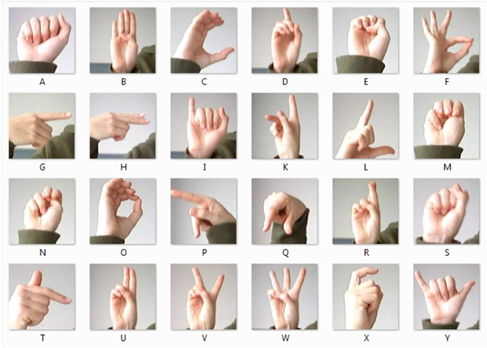

In [3]:
train = pd.read_csv('https://raw.githubusercontent.com/gurpreet0610/sign_language_CNN/master/sign-language-mnist/sign_mnist_test.csv')
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,152,152,152,152,152,153,153,151,152,152,153,152,152,151,151,150,150,150,149,150,150,150,152,152,151,152,152,152,152,152,...,131,134,144,147,125,87,87,103,107,110,116,113,75,74,74,74,76,74,82,134,168,155,146,137,145,146,149,135,124,125,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,138,137,137,138,138,139,137,142,140,138,139,137,137,136,135,134,133,134,132,129,132,134,135,135,137,139,139,139,140,141,...,114,112,89,48,133,194,182,185,184,184,182,181,172,174,177,178,178,179,181,183,187,175,165,154,118,107,100,75,96,83,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,152,157,163,168,171,182,172,175,185,183,184,185,185,185,183,183,182,181,178,86,88,93,96,108,125,137,145,149,154,160,...,145,123,78,162,239,227,229,226,226,225,224,222,89,91,94,111,136,154,167,184,125,3,166,225,195,188,172,185,161,122,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,209,208,207,207,209,208,210,210,207,209,209,208,209,210,209,207,208,209,207,206,208,209,208,208,210,211,210,211,209,209,...,85,80,84,151,238,255,255,250,237,245,250,232,103,101,102,103,95,208,231,227,209,190,179,182,152,150,159,119,83,63,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,203,204,204,204,203,202,198,216,217,135,181,200,195,194,193,190,189,187,185,190,194,196,197,200,202,204,206,207,207,206,...,93,52,24,53,63,33,41,51,48,45,49,55,149,150,150,148,147,151,124,82,84,81,69,81,111,103,84,75,53,28,26,40,64,48,29,46,49,46,46,53


The dataset has 25 unique labels to representing the number of distinct sign-languages.
For the sake of the GPU, we are going to consider only first 10 labels, omitting the rest.
You are encouraged to try for all the labesl :)

In [4]:
# Selecting only first 10 labels
train = train[train['label'] < 10]
# Setting the label and the feature columns
y = train.loc[:,'label'].values
x = train.loc[:,'pixel1':].values

### Plotting functions
To make it easier and simplier to plot our results

In [5]:
# Function to plot 2D graphs
def plot_2d(component1, component2):
    
    fig = go.Figure(data=go.Scatter(
        x = component1,
        y = component2,
        mode='markers',
        marker=dict(
            size=20,
            color=y, #set color equal to a variable
            colorscale='Rainbow', # one of plotly colorscales
            showscale=True,
            line_width=1
        )
    ))
    fig.update_layout(margin=dict( l=100,r=100,b=100,t=100),width=2000,height=1200)                 
    fig.layout.template = 'plotly_dark'
    
    fig.show()

In [6]:
# Function for 3D plots
def plot_3d(component1,component2,component3):
  fig = go.Figure(data=[go.Scatter3d(
  x=component1,
  y=component2,
  z=component3,
  mode='markers',
  marker=dict(
      size=10,
      color=y,                # set color to an array/list of desired values
      colorscale='Rainbow',   # choose a colorscale
      opacity=1,
      line_width=1
  )
  )])
  # tight layout
  fig.update_layout(margin=dict(l=50,r=50,b=50,t=50),width=1800,height=1000)
  fig.layout.template = 'plotly_dark'

  fig.show()

### Standardizing the data

In [7]:
from sklearn.preprocessing import StandardScaler
## Standardizing the data
x = StandardScaler().fit_transform(x)

### PCA
#### Implementing the PCA

In [8]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principal = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])
%load_ext autotime

time: 175 µs (started: 2022-02-19 20:05:52 +00:00)


Applying PCA changes our data from 784 features to 3 features i.e., reduces the feature dimensions.
The number of dimensions has been reduced drastically while it retains as much information as possible for the data points.

#### PCA -- 2D

In [9]:
plot_2d(principalComponents[:, 0],principalComponents[:, 1])

time: 483 ms (started: 2022-02-19 20:05:52 +00:00)


It can be seen the two components we selected hold some information, espeically for the specific digits.
Not enough to set all of them apart.
#### PCA -- 3D

In [10]:
plot_3d(principalComponents[:, 0],principalComponents[:, 1],principalComponents[:, 2])

time: 66.2 ms (started: 2022-02-19 20:05:52 +00:00)


### t-SNE
t-SNE is computionally very expensives!
So we apply PCA to retain 50 principle components from the orignal data
Cuts down the need for more processing power and reduce time.


In [11]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(x)
tsne = TSNE(random_state = 42, n_components=3,verbose=0, perplexity=40, n_iter=400).fit_transform(pca_result_50)
%load_ext autotime

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1min 4s (started: 2022-02-19 20:05:52 +00:00)


#### t-SNE -- 2D

In [12]:
plot_2d(tsne[:, 0],tsne[:, 1])

time: 42.4 ms (started: 2022-02-19 20:06:57 +00:00)


Takeway: Compared to PCA, we see more presence of different clusters with their position.

#### t-SNE -- 3D

In [13]:
plot_3d(tsne[:, 0],tsne[:, 1],tsne[:, 2])

time: 56.6 ms (started: 2022-02-19 20:06:57 +00:00)


### UMAP
UMAP has different hyperparameters that impact the result.

1. `n_neighbors`
Controls the blanace between local and global structure of the data.
> Low value: Focuses on local structure
> 
> High value: Focuses on global structure

2. `min_dist`
Controls how tight the data points should be. 
> Low value: Cluster closed

3. `n_components`
Controls the dimensionlity of the reduced dimension space

4. `metric`
Controls the distance computation algorithm

#### Implmentation

In [14]:
reducer = umap.UMAP(random_state=42,n_components=3)
embedding = reducer.fit_transform(x)
%load_ext autotime

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.



The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 23.9 s (started: 2022-02-19 20:06:57 +00:00)


#### UMAP -- 2D

In [15]:
plot_2d(reducer.embedding_[:, 0],reducer.embedding_[:, 1])

time: 43.5 ms (started: 2022-02-19 20:07:21 +00:00)


In [16]:
plot_3d(reducer.embedding_[:, 0],reducer.embedding_[:, 1],reducer.embedding_[:, 2])

time: 52 ms (started: 2022-02-19 20:07:21 +00:00)


Clearly UMAP does better job at seperating the points compared to others.
BUT, we do not get big clusters!

### LDA

In [17]:
X_LDA = LDA(n_components=3).fit_transform(x,y)

time: 1.31 s (started: 2022-02-19 20:07:21 +00:00)


#### LDA -- 2D

In [18]:
plot_2d(X_LDA[:, 0],X_LDA[:, 1])

time: 59.8 ms (started: 2022-02-19 20:07:23 +00:00)


#### LDA -- 3D

In [19]:
plot_3d(X_LDA[:, 0],X_LDA[:, 1],X_LDA[:, 2])

time: 64.9 ms (started: 2022-02-19 20:07:23 +00:00)


LDA makes clear distinction of the the nine clusters with noticeable distance between them